## Running from star to snowflake

We will convert the current star schema into a snowflake schema. To do this, we normalize route_dim and week_dim. Which option best describes the resulting new tables after doing this?

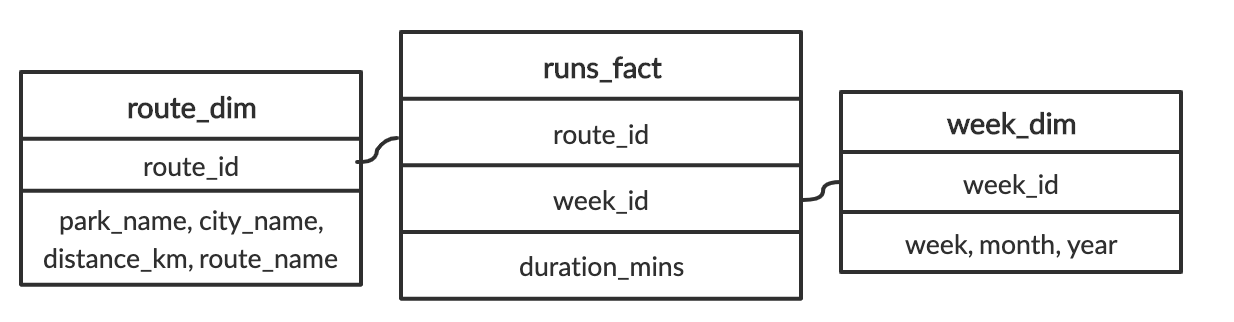

week_dim is extended two dimensions with new tables for month and year. route_dim is extended two dimensions with new tables for city and park.

## Adding foreign keys
Foreign key references are essential to both the snowflake and star schema. When creating either of these schemas, correctly setting up the foreign keys is vital because they connect dimensions to the fact table. They also enforce a one-to-many relationship, because unless otherwise specified, a foreign key can appear more than once in a table and primary key can appear only once.

The fact_booksales table has three foreign keys: book_id, time_id, and store_id. The four tables that make up the star schema below have been loaded. However, the foreign keys still need to be added.

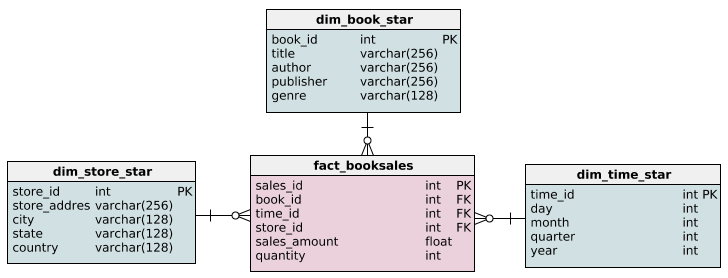

- In the constraint called sales_book, set book_id as a foreign key.
- In the constraint called sales_time, set time_id as a foreign key.
- In the constraint called sales_store, set store_id as a foreign key.

In [ ]:
-- Add the book_id foreign key
ALTER TABLE fact_booksales ADD CONSTRAINT sales_book
    FOREIGN KEY (book_id) REFERENCES dim_book_star (book_id);
    
-- Add the time_id foreign key
ALTER TABLE fact_booksales ADD CONSTRAINT  sales_time
    FOREIGN KEY (time_id) REFERENCES dim_time_star (time_id);
    
-- Add the store_id foreign key
ALTER TABLE fact_booksales ADD CONSTRAINT sales_store
    FOREIGN KEY (store_id) REFERENCES dim_store_star (store_id);

## Extending the book dimension
We saw how the book dimension differed between the star and snowflake schema. The star schema's dimension table for books, dim_book_star, has been loaded and below is the snowflake schema of the book dimension.

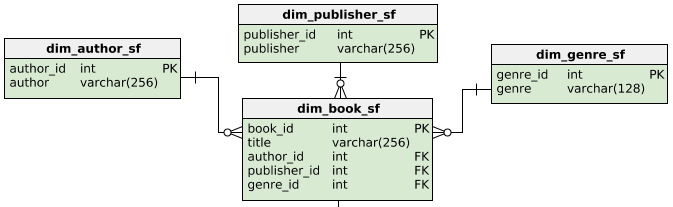

We are going to extend the star schema to meet part of the snowflake schema's criteria. Specifically, we will create dim_author from the data provided in dim_book_star.


Insert all the distinct authors from dim_book_star into dim_author.

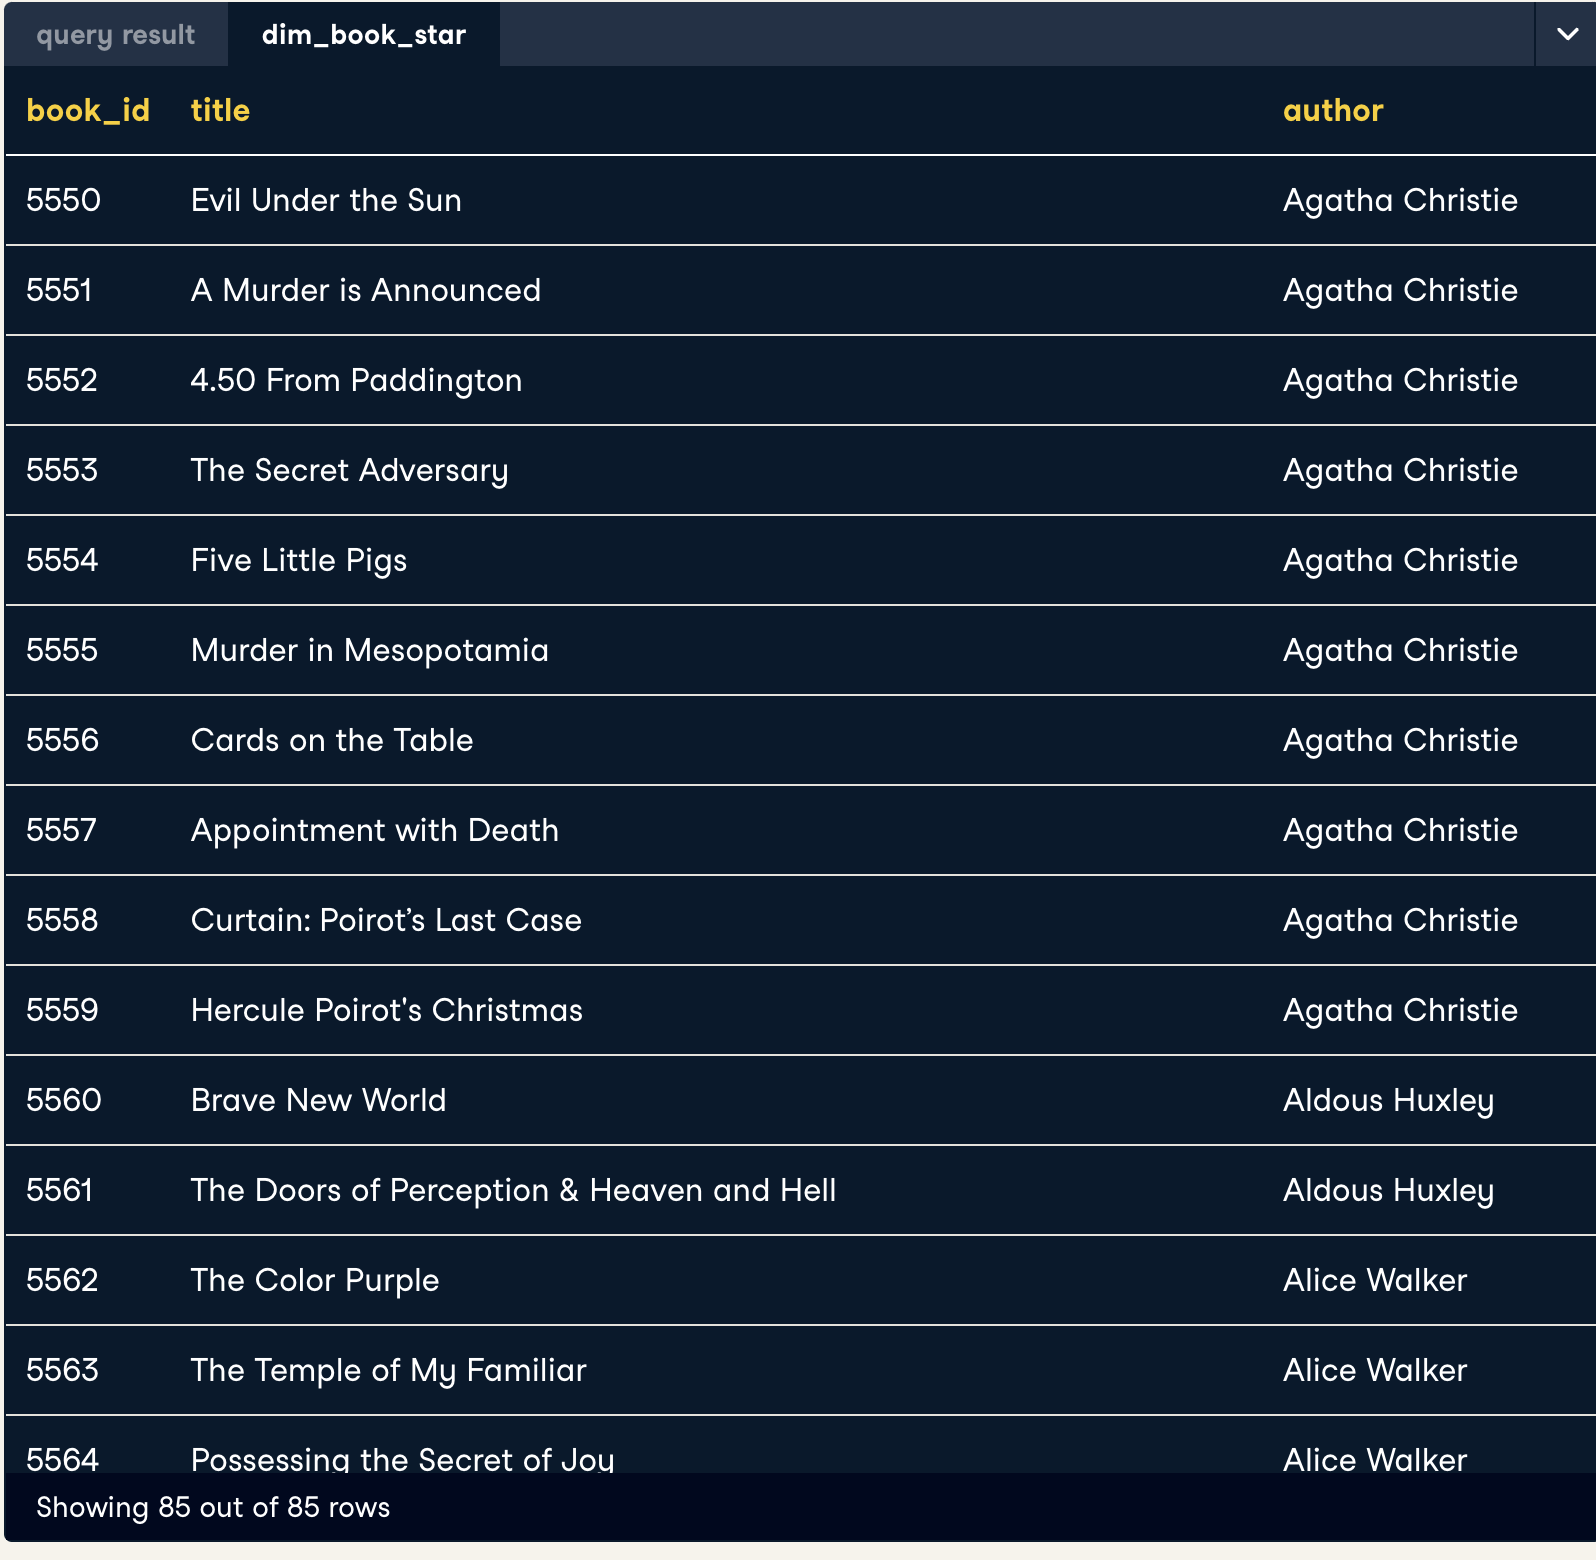

In [ ]:
-- Create dim_author with an author column
CREATE TABLE dim_author (
    author VARCHAR(256)  NOT NULL
);

-- Insert authors into the new table
INSERT INTO dim_author
SELECT DISTINCT author FROM dim_book_star;

In [ ]:
-- Add a primary key author_id
ALTER TABLE dim_author ADD COLUMN author_id SERIAL PRIMARY KEY;

-- Output the new table
SELECT * FROM dim_author;

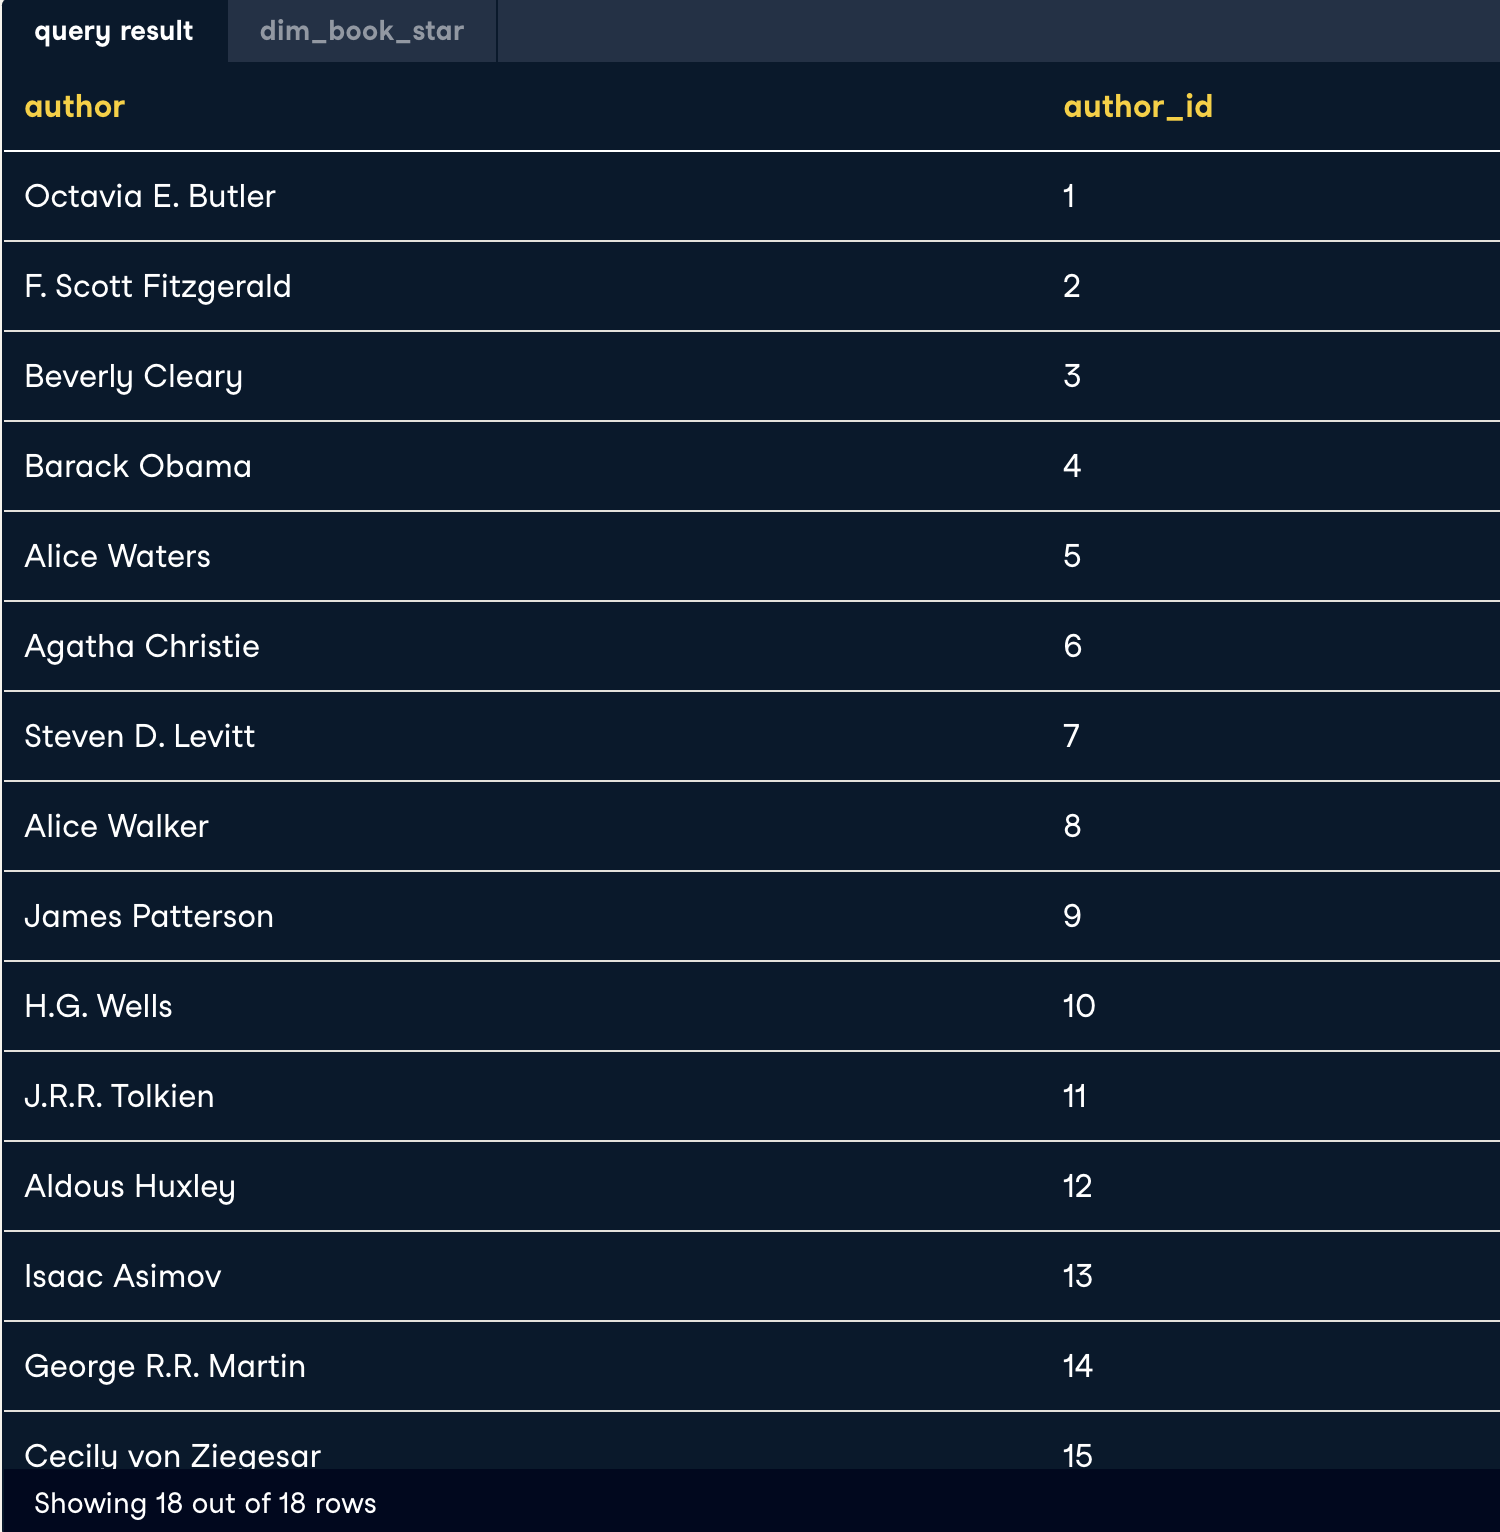

We've created a dimension table that succesfully meets the schema criteria - it has all the authors with no repeats and unique author_ids. If we were to continue completing the star schema, we would need to create tables for the other dimensions using similar code.

## Querying the star schema
The novel genre hasn't been selling as well as our company predicted. To help remedy this, we've been tasked to run some analytics on the novel genre to find which areas the Sales team should target. To begin, we want to look at the total amount of sales made in each state from books in the novel genre.

Luckily, we've just finished setting up a data warehouse with the following star schema:

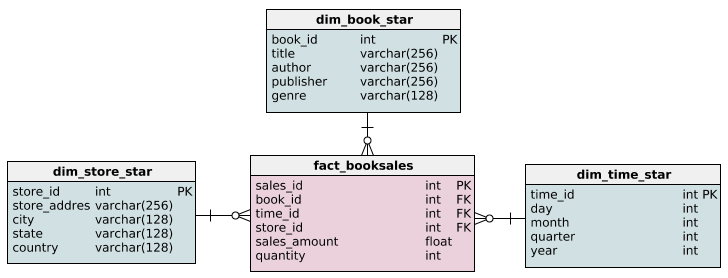


- Select state from the appropriate table and the total sales_amount.
- Complete the JOIN on book_id.
- Complete the JOIN to connect the dim_store_star table
- Conditionally select for books with the genre novel.
- Group the results by state.

In [ ]:
-- Output each state and their total sales_amount
SELECT dim_store_star.state,SUM(sales_amount)
FROM fact_booksales
	-- Join to get book information on book_id
    JOIN dim_book_star on dim_book_star.book_id = fact_booksales.book_id
	-- Join to get store information 
    JOIN dim_store_star on dim_store_star.store_id = fact_booksales.store_id
-- Get all books with in the novel genre
WHERE  
    dim_book_star.genre = 'novel'
-- Group results by state
GROUP BY
    dim_store_star.state;

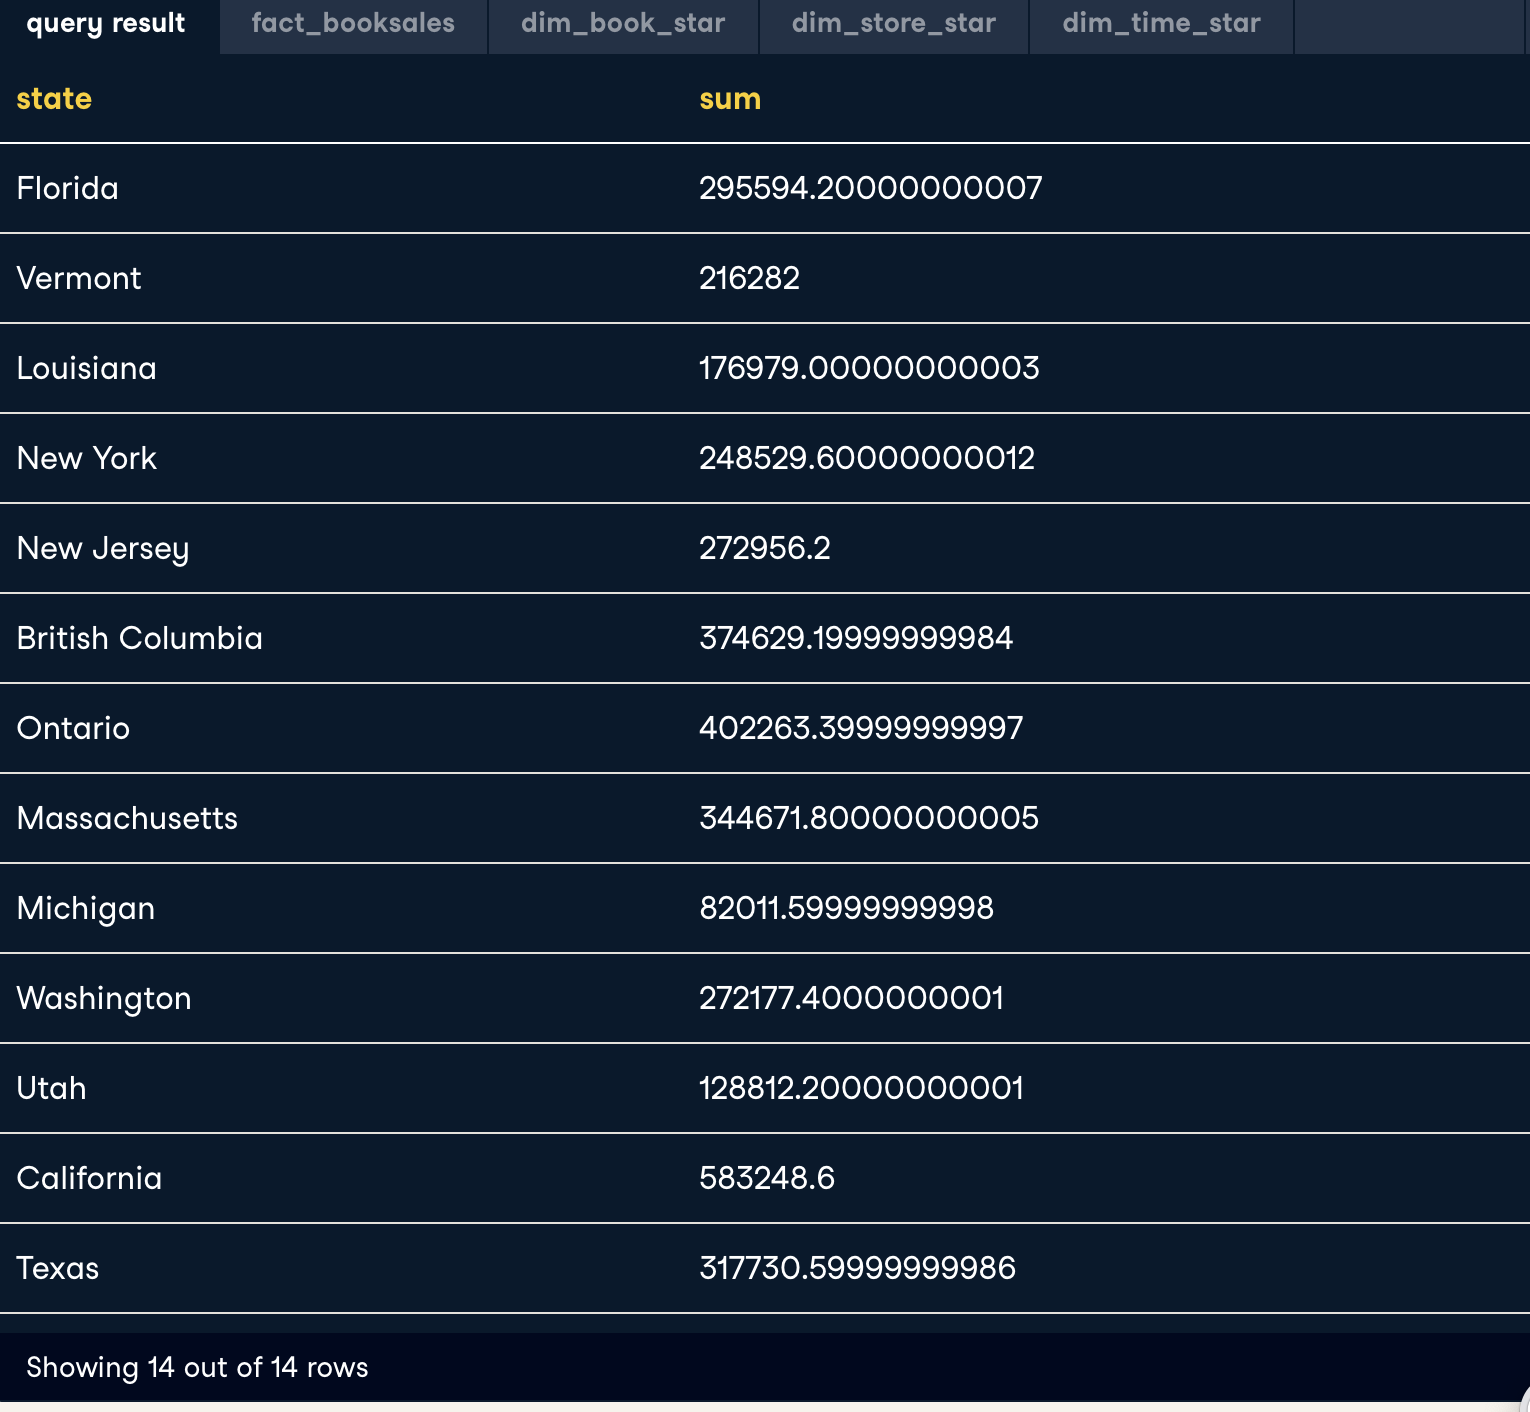

Quality query! We now have a nice list of the amount of money made from novels in each state. Note that it took only two joins to run this query.

## Querying the snowflake schema
Imagine that we didn't have the data warehouse set up. Instead, we'll have to run this query on the company's operational database, which means we'll have to rewrite the previous query with the following snowflake schema:

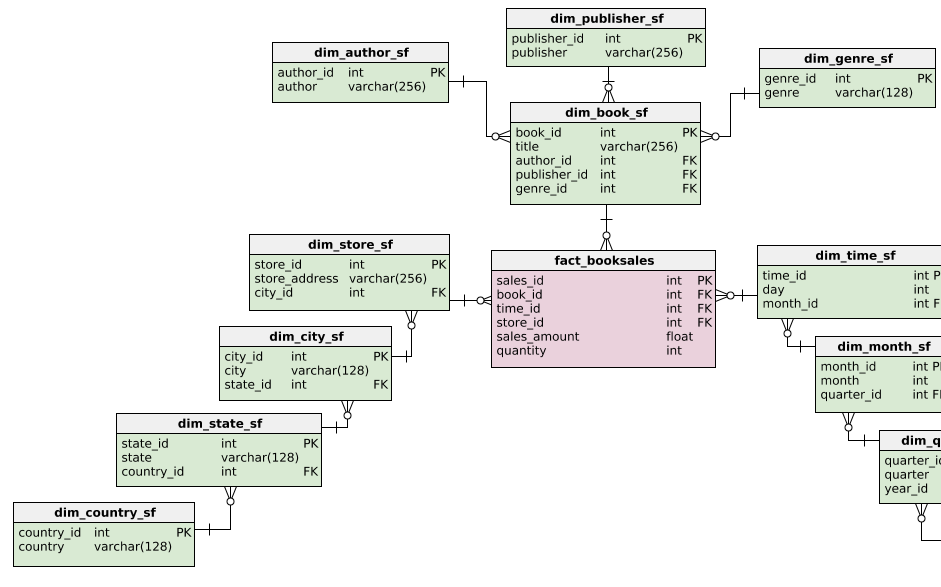

 Our goal is to find the amount of money made from the novel genre in each state.

- Select state from the appropriate table and the total sales_amount.
- Complete the two JOINS to get the genre_id's.
- Complete the three JOINS to get the state_id's.
- Conditionally select for books with the genre novel.
- Group the results by state.



In [ ]:
-- Output each state and their total sales_amount
SELECT dim_state_sf.state, SUM(sales_amount)
FROM fact_booksales
    -- Joins for genre
    JOIN dim_book_sf on dim_book_sf.book_id = fact_booksales.book_id
    JOIN dim_genre_sf on dim_book_sf.genre_id = dim_genre_sf.genre_id
    -- Joins for state 
    JOIN dim_store_sf on dim_store_sf.store_id = fact_booksales.store_id 
    JOIN dim_city_sf on dim_city_sf.city_id = dim_store_sf.city_id
	JOIN dim_state_sf on  dim_state_sf.state_id = dim_city_sf.state_id
-- Get all books with in the novel genre and group the results by state
WHERE  
    dim_genre_sf.genre = 'novel'
GROUP BY
    dim_state_sf.state;

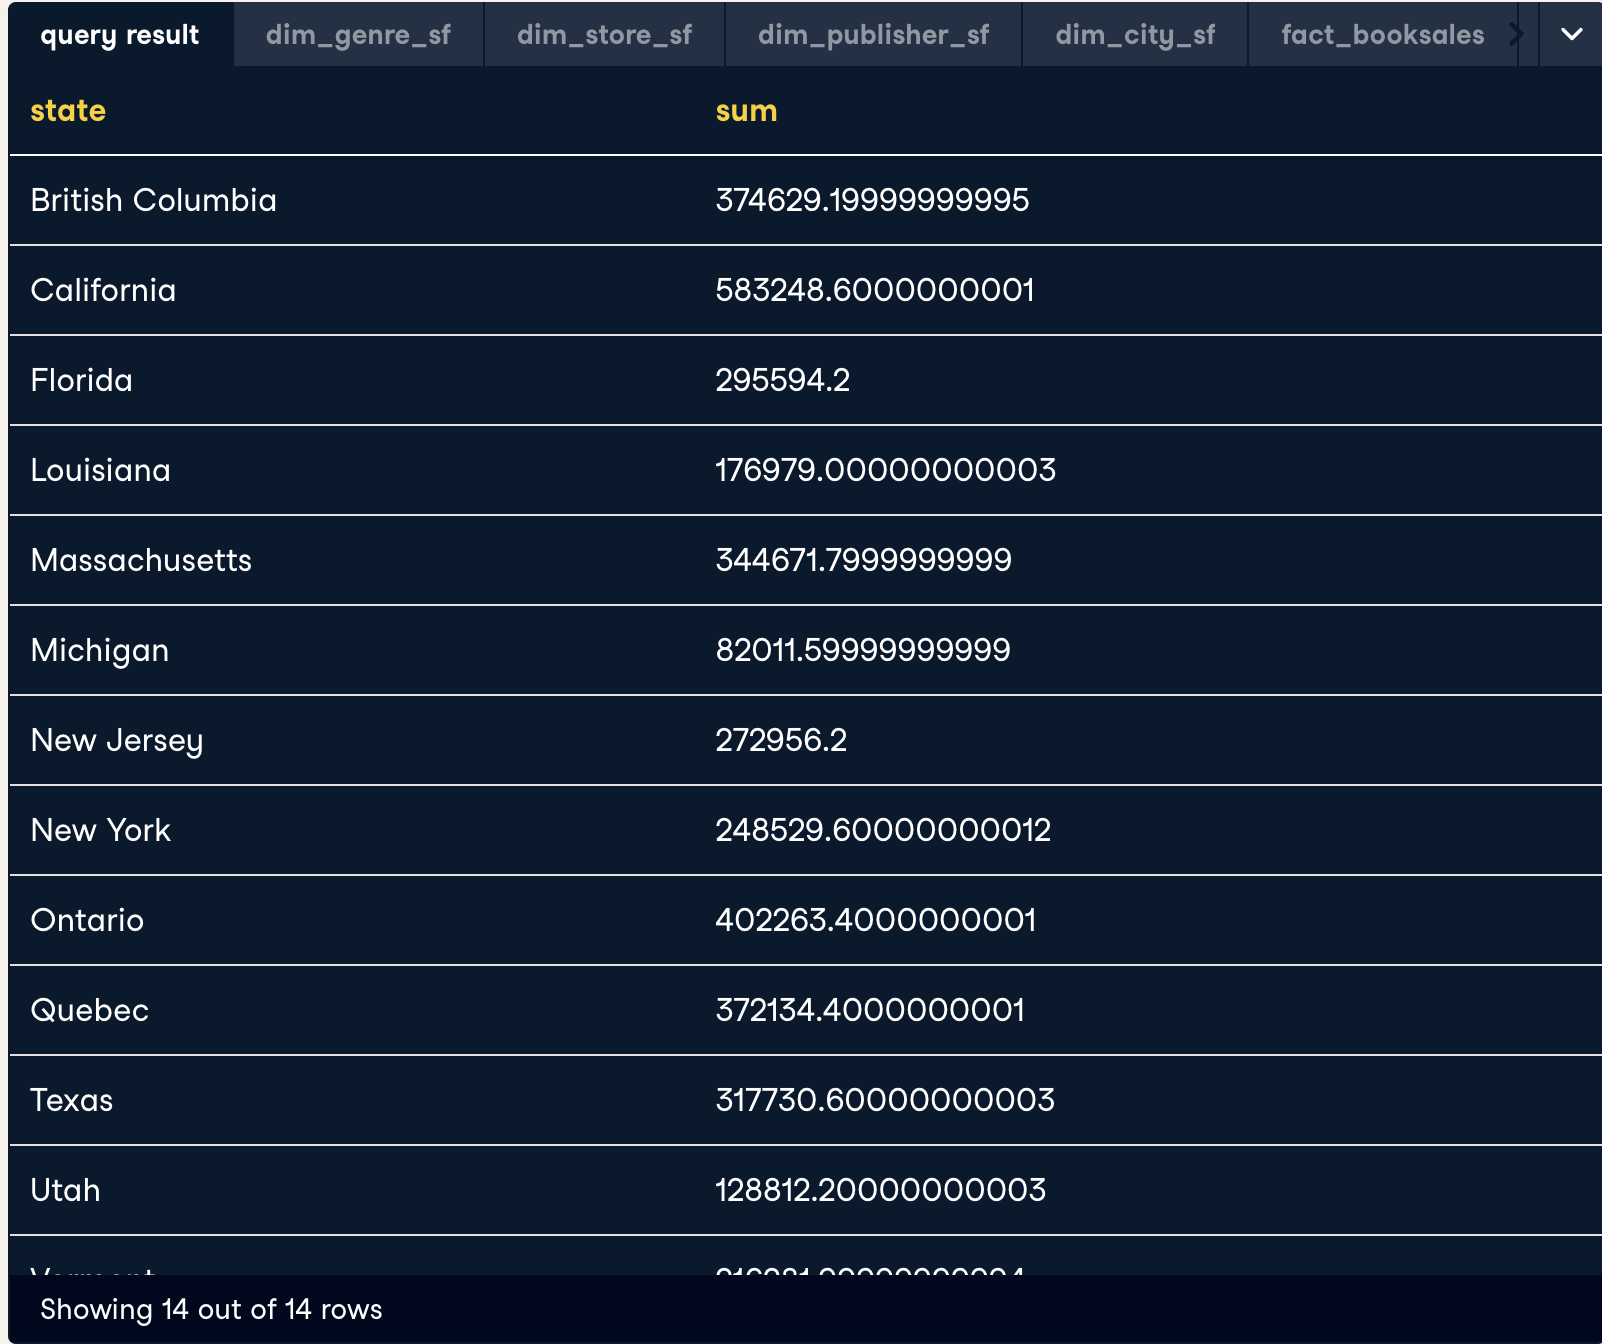

This query was definitely more work than the previous one. It wouldn't be practical to have to think about all these joins if we're doing a lot of analytics.

## Updating countries
Going through the company data, we notice there are some inconsistencies in the store addresses. These probably occurred during data entry, where people fill in fields using different naming conventions. This can be especially seen in the country field, and we decide that countries should be represented by their abbreviations. The only countries in the database are Canada and the United States, which should be represented as USA and CA.

We will compare the records that need to be updated.

Output all the records that need to be updated in the star schema so that countries are represented by their abbreviations.

In [ ]:
-- Output records that need to be updated in the star schema
SELECT * FROM dim_store_star
WHERE country != 'USA' AND country !='CA';

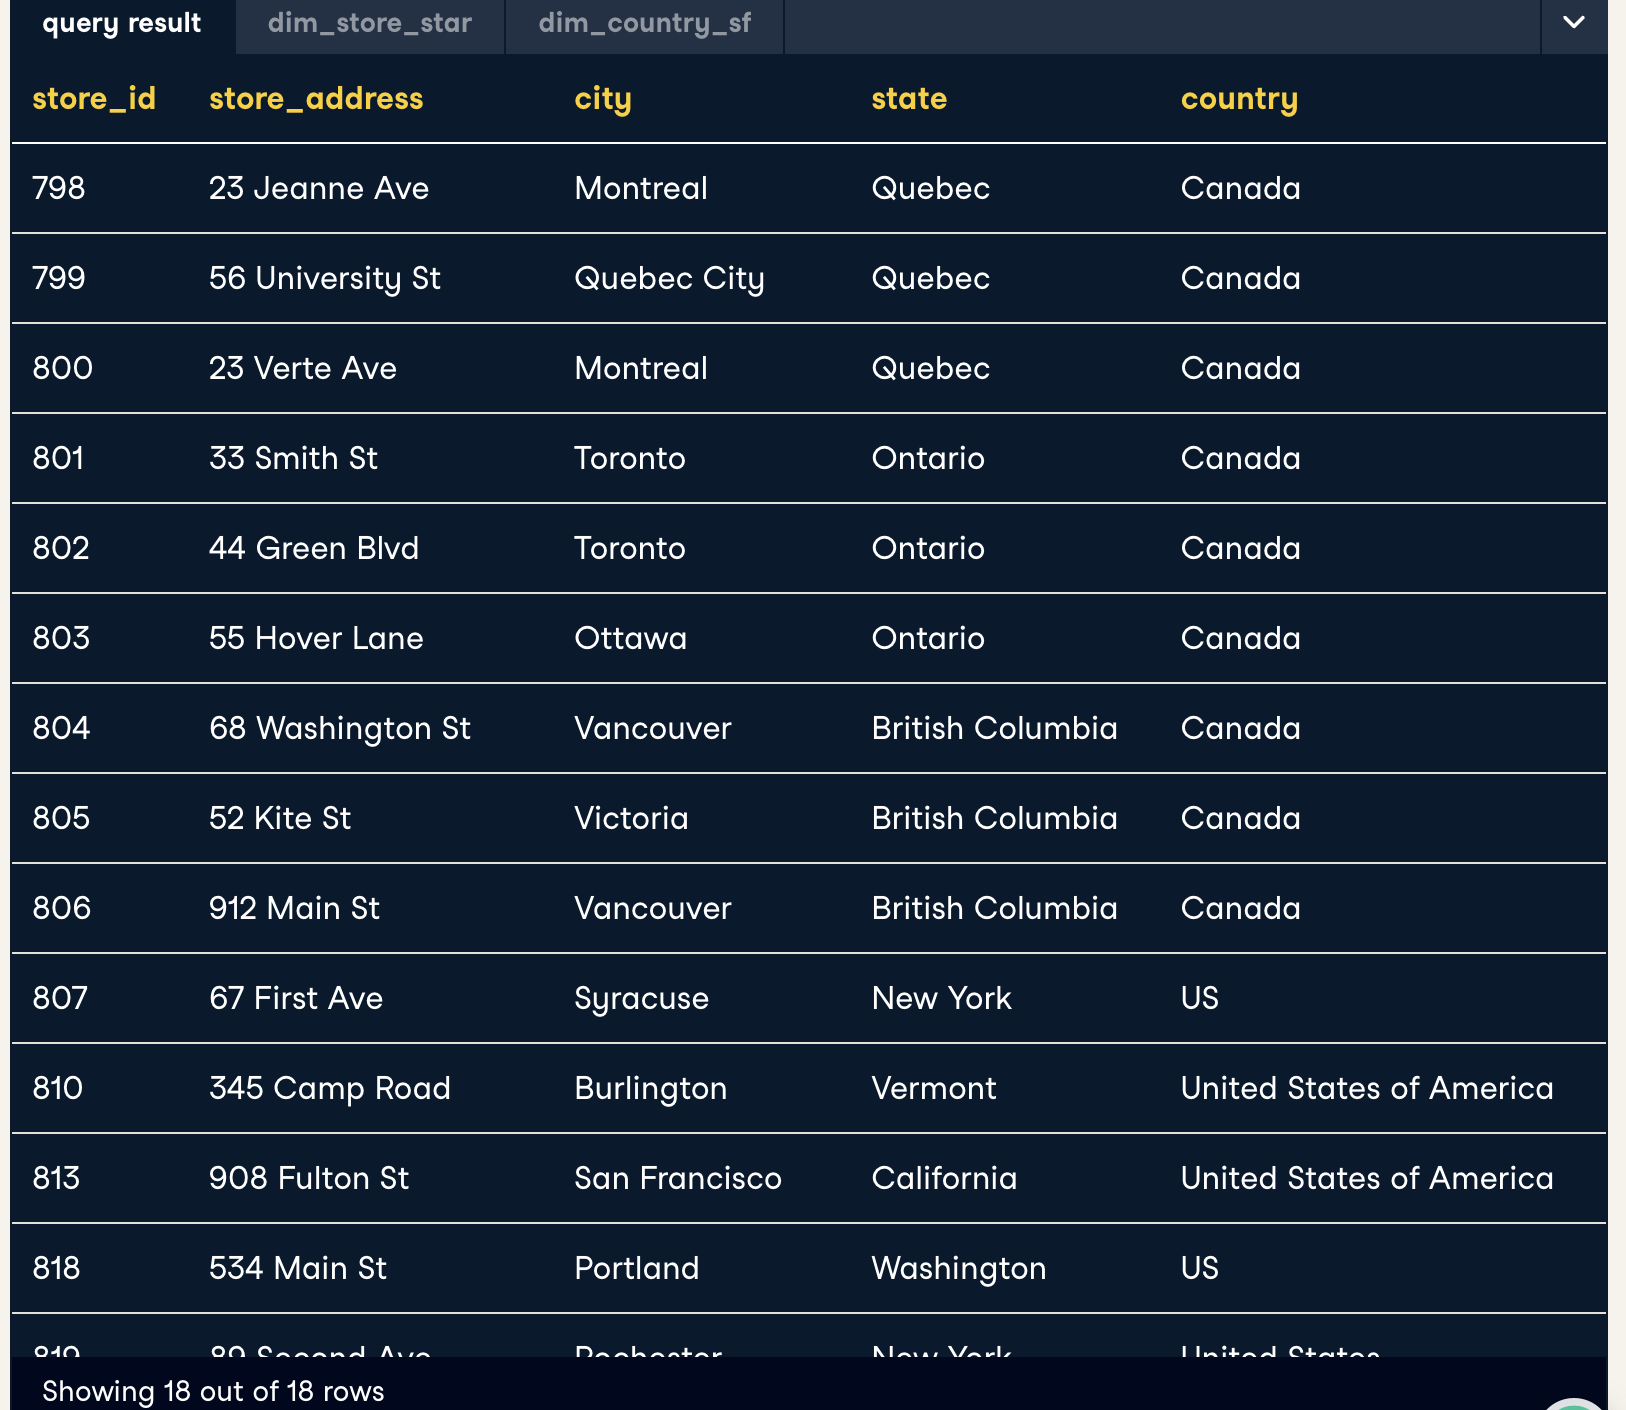

In [ ]:
-- Output records that need to be updated in the snowflake schema
SELECT * FROM dim_country_sf
WHERE country != 'USA' AND country !='CA';

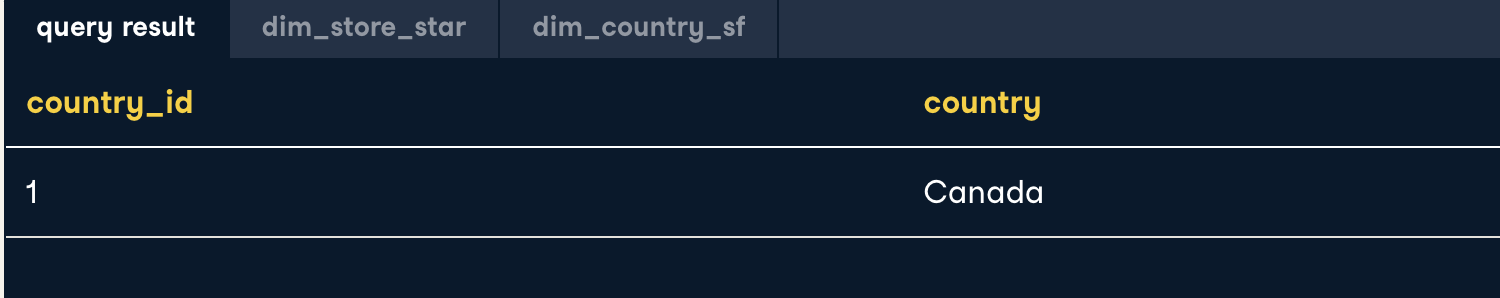

 Only one record needs to be changed - Canada to CA. Updating is typically simpler in a snowflake schema because there are less records to update because redundant values are minimized to their own table (e.g., countries have their own table, dim_country_sf). Snowflake schemas are also better at enforcing naming conventions due to referential integrity. Note how there weren't any variations in how Canada and USA were referred to in the snowflake schema.

## Extending the snowflake schema
The company is thinking about extending their business beyond bookstores in Canada and the US. Particularly, they want to expand to a new continent. In preparation, we decide a continent field is needed when storing the addresses of stores.

Luckily, we have a snowflake schema in this scenario. The snowflake schema is typically faster to extend while ensuring data consistency. Along with dim_country_sf, a table called dim_continent_sf has been loaded. It contains the only continent currently needed, North America, and a primary key. We'll need to extend dim_country_sf to reference dim_continent_sf.

- Add a continent_id column to dim_country_sf with a default value of 1. Note thatNOT NULL DEFAULT(1) constrains a value from being null and defaults its value to 1.
- Make that new column a foreign key reference to dim_continent_sf's continent_id.

In [ ]:
-- Add a continent_id column with default value of 1
ALTER TABLE dim_country_sf
ADD continent_id int NOT NULL DEFAULT(1);

-- Add the foreign key constraint
ALTER TABLE dim_country_sf ADD CONSTRAINT country_continent
   FOREIGN KEY (continent_id) REFERENCES dim_continent_sf(continent_id);
   
-- Output updated table
SELECT * FROM dim_country_sf;

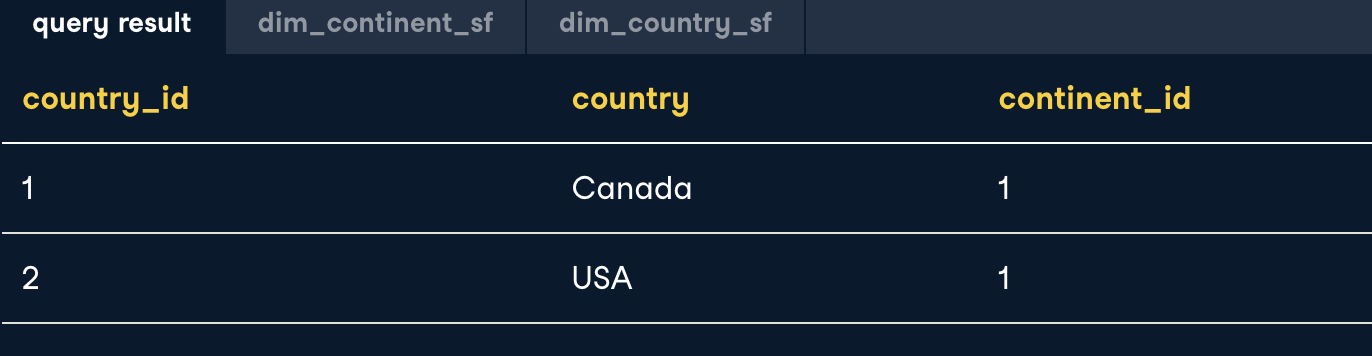

We have successfully extended the snowflake schema to have continents. That wasn't too bad as it only required altering one table and we can be sure of data consistency. This type of extension is a big benefit of the snowflake schema.

## Converting to 1NF
We'll be working through different tables belonging to a car rental company. Our job is to explore different schemas and gradually increase the normalization of these schemas through the different normal forms. At this stage, we're not worried about relocating the data, but rearranging the tables.

A table called customers has been loaded, which holds information about customers and the cars they have rented.


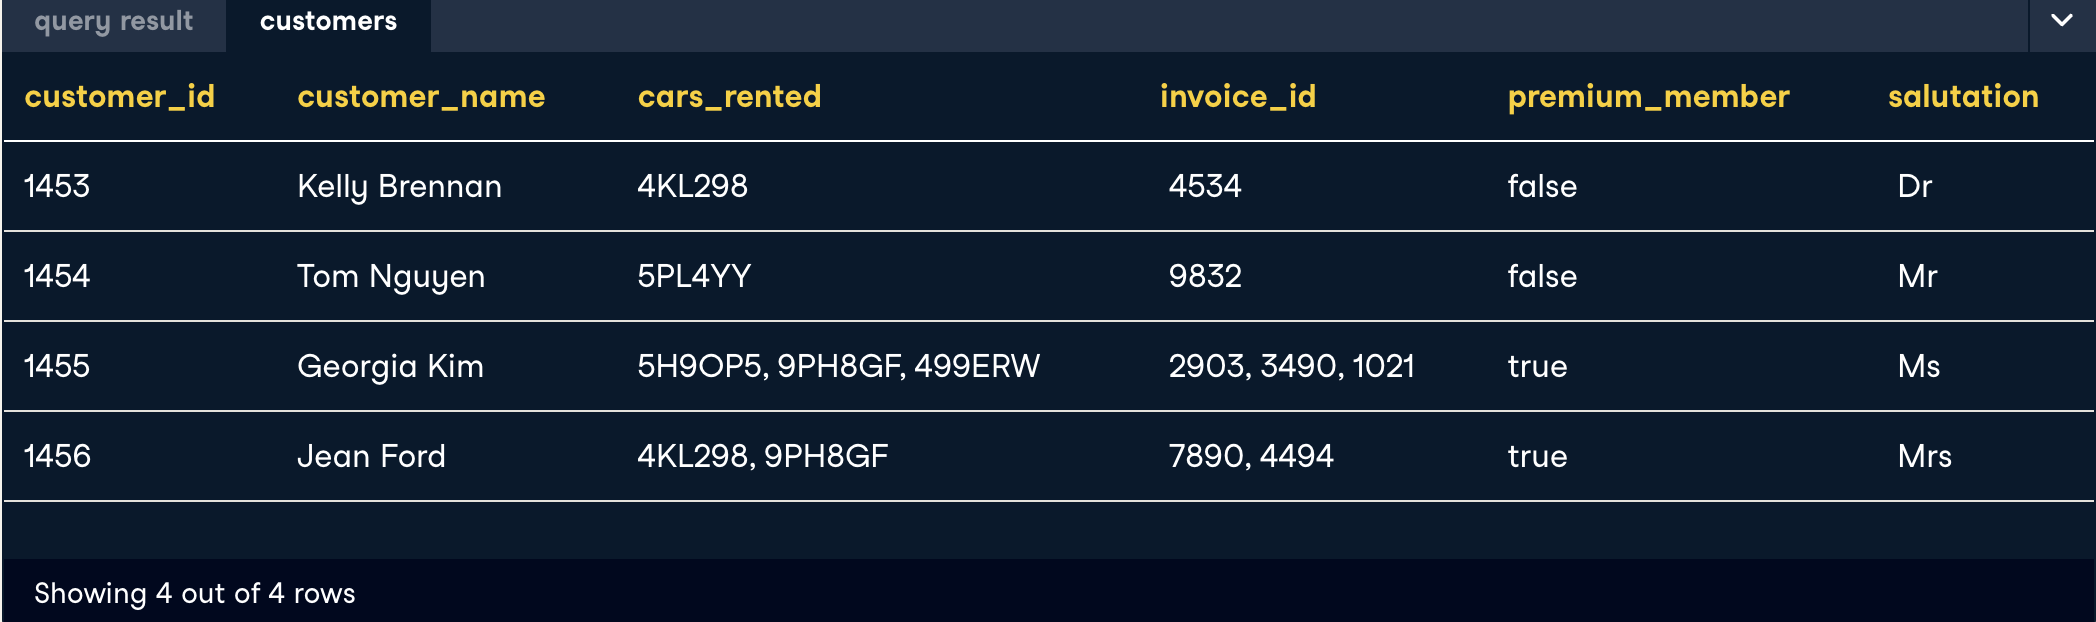


Does the customers table meet 1NF criteria?

- No, because there are multiple values in cars_rented and invoice_id

- cars_rented holds one or more car_ids and invoice_id holds multiple values. Create a new table to hold individual car_ids and invoice_ids of the customer_ids who've rented those cars.
- Drop two columns from customers table to satisfy 1NF

In [ ]:
-- Create a new table to hold the cars rented by customers
CREATE TABLE cust_rentals (
  customer_id INT NOT NULL,
  car_id VARCHAR(128) NULL,
  invoice_id VARCHAR(128) NULL
);

-- Drop column from customers table to satisfy 1NF
ALTER TABLE customers
DROP COLUMN customer_id,
DROP COLUMN invoice_id;


We now have two tables: (1) customers which holds customer information and (2) cust_rentals which holds the car_ids rented by different customer_ids. This satisfies 1NF. In a real situation, we would need to fill the new table before dropping any columns.

## Converting to 2NF
Let's try normalizing a bit more. We created a table holding customer_ids and car_ids.

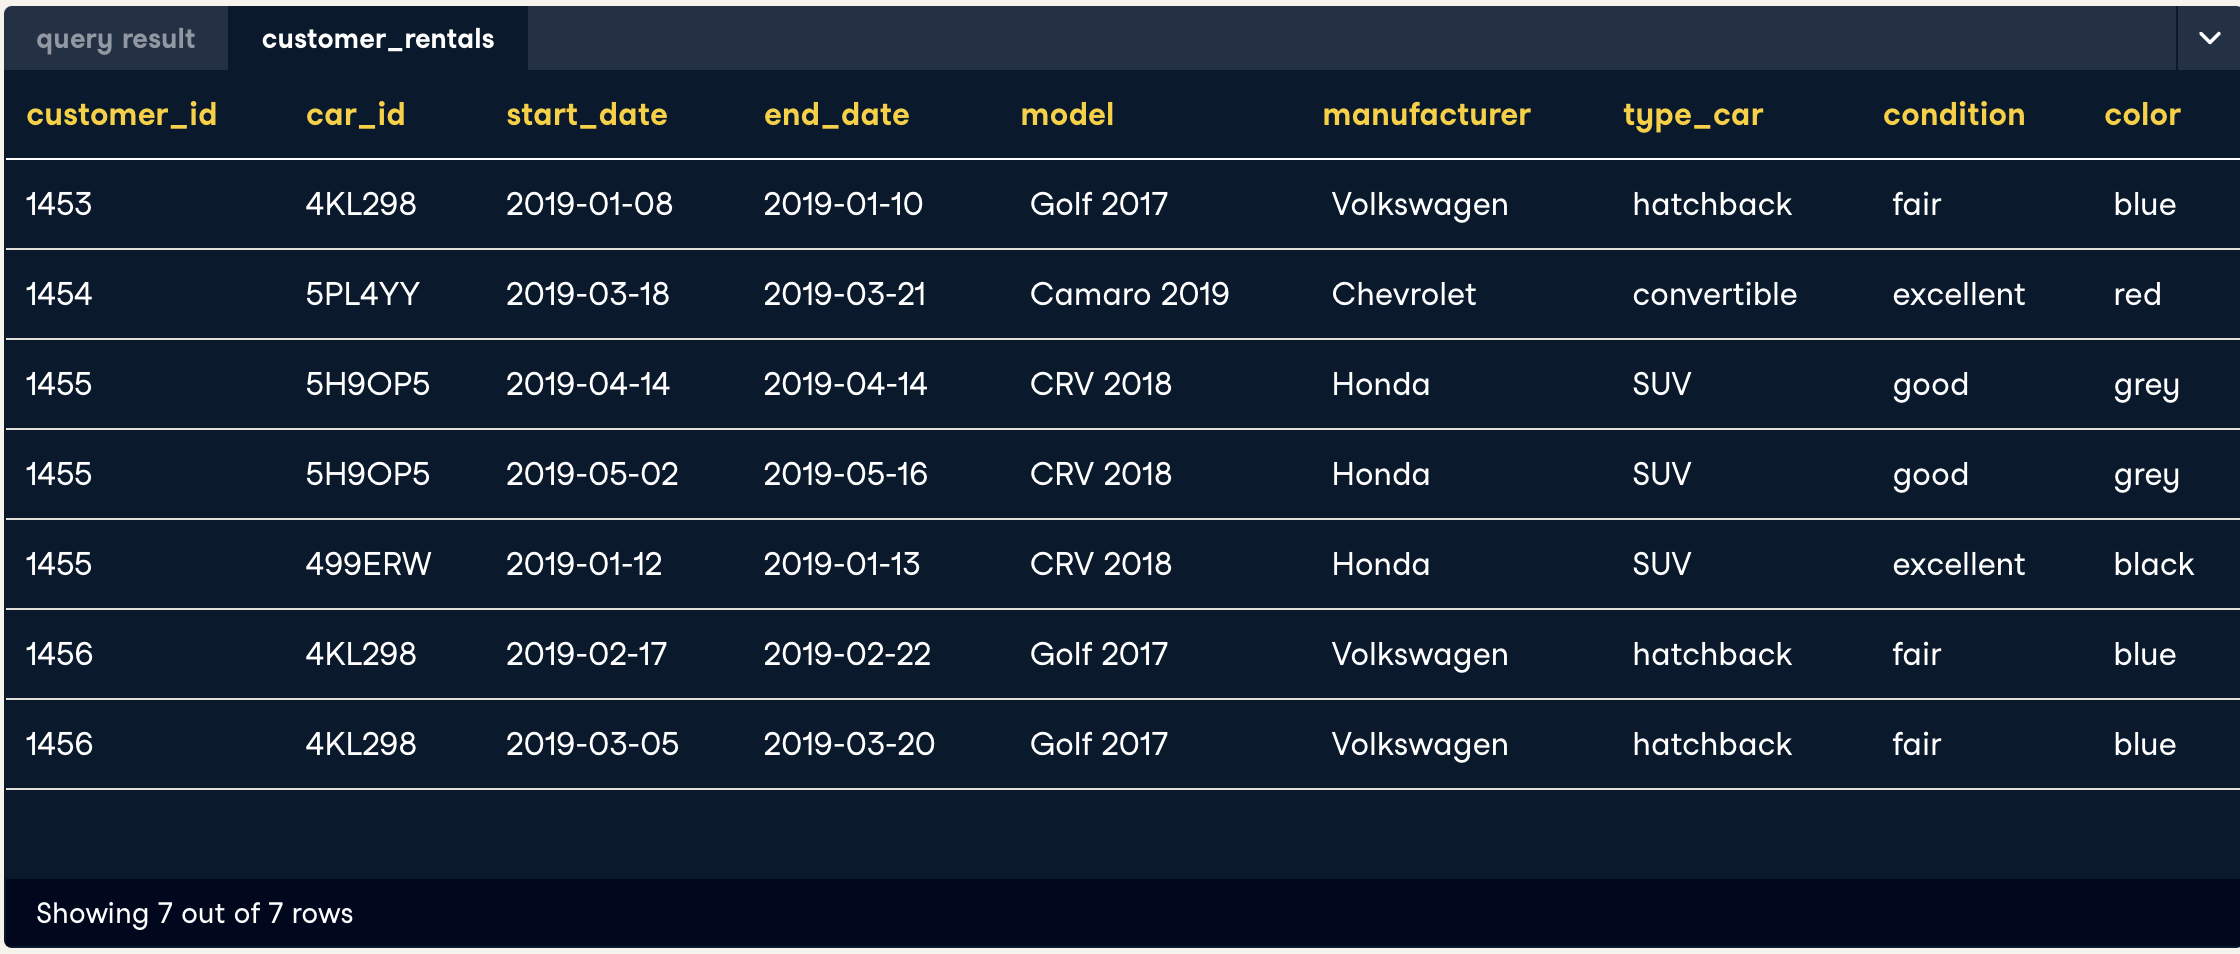

Why doesn't customer_rentals meet 2NF criteria?

Because there are non-key attributes describing the car that only depend on one primary key, car_id.

- Create a new table for the non-key columns that were conflicting with 2NF criteria.
- Drop those non-key columns from customer_rentals.



In [ ]:
-- Create a new table to satisfy 2NF
CREATE TABLE cars (
  car_id VARCHAR(256) NULL,
  model VARCHAR(128),
  manufacturer VARCHAR(128),
  type_car VARCHAR(128),
  condition VARCHAR(128),
  color VARCHAR(128)
);

-- Drop columns in customer_rentals to satisfy 2NF
ALTER  TABLE customer_rentals
DROP  COLUMN model,
DROP  COLUMN manufacturer, 
DROP  COLUMN  type_car,
DROP  COLUMN condition,
DROP  COLUMN color;

model, manufacturer, type_car, conditions, and colors depend on car_id, but are independent of the other two primary keys, customer_id and start_date. The customer or start date cannot change these attributes. Hence, we have put these columns in a new table and dropped them from customer_rentals.

## Converting to 3NF
Last, but not least, we are at 3NF. We created a table holding car_idss and car attributes. This has been expanded upon. For example, car_id is now a primary key. The resulting table, rental_cars, has been loaded for you.

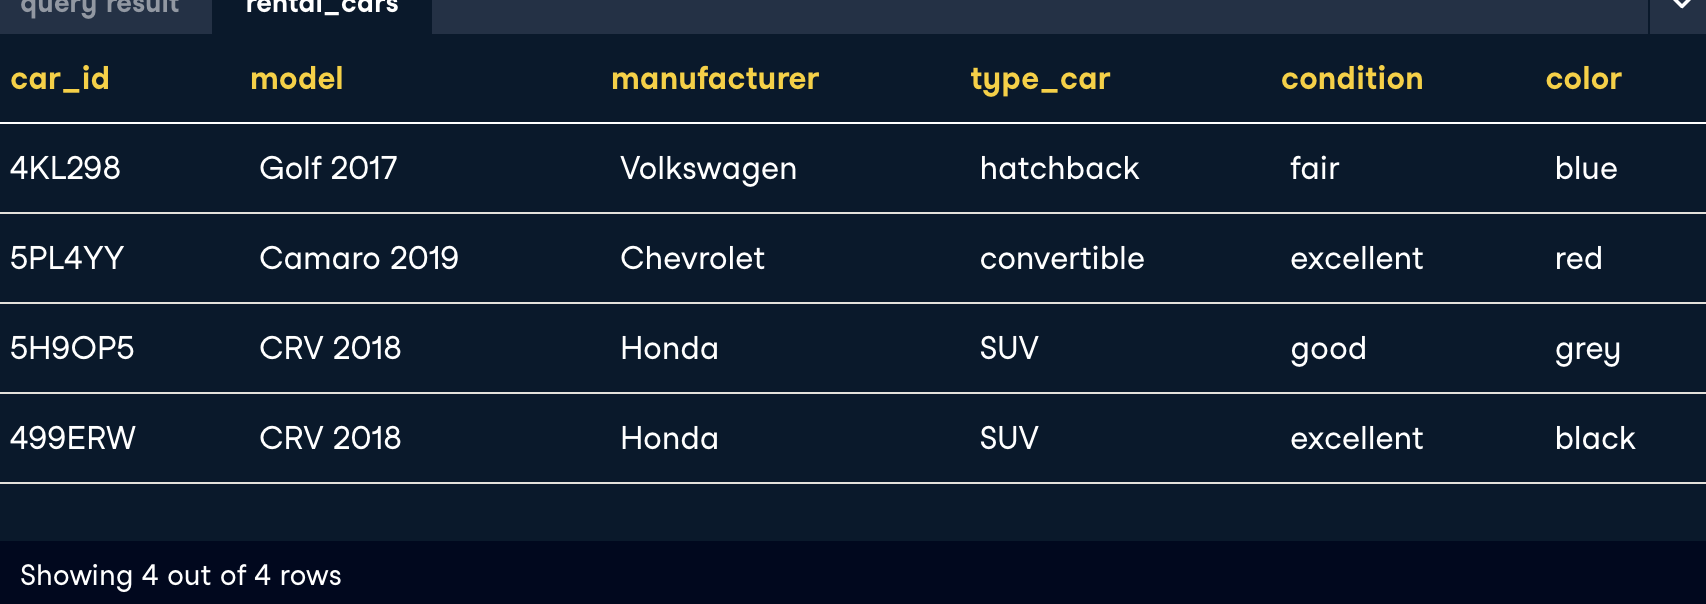



Why doesn't rental_cars meet 3NF criteria?

Because there are two columns that depend on the non-key column, model.

- Create a new table for the non-key columns that were conflicting with 3NF criteria.
- Drop those non-key columns from rental_cars.

In [ ]:
-- Create a new table to satisfy 3NF
CREATE TABLE car_model(
  model VARCHAR(128),
  manufacturer VARCHAR(128),
  type_car VARCHAR(128)
);

-- Drop columns in rental_cars to satisfy 3NF
ALTER TABLE rental_cars
DROP COLUMN manufacturer, 
DROP COLUMN type_car;